In [1]:
CSV_PATH = '/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv'
IMG_PATH = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
GLOVE_300 = '/kaggle/input/glove-300d/glove.42B.300d.txt'

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
import pandas as pd
from spacy.lang.en import English
import torchtext
from sklearn.model_selection import train_test_split
import tqdm
seed = 1234
import random
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
df = pd.read_csv(CSV_PATH, delimiter='|')
df.dropna(inplace=True)
df = df.iloc[:2000]
df.head(5)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_name       2000 non-null   object
 1    comment_number  2000 non-null   object
 2    comment         2000 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB


In [6]:
train, remaining = train_test_split(df, test_size=0.2, random_state=42)

test, val = train_test_split(remaining, test_size=0.5, random_state=42)

print("Size of train set:", len(train))
print("Size of test set:", len(test))
print("Size of validation set:", len(val))

Size of train set: 1600
Size of test set: 200
Size of validation set: 200


In [7]:
def load_data(df):
    return df.to_dict(orient='list')

In [8]:
train_data = load_data(train[["image_name"," comment"]])
test_data = load_data(test[["image_name"," comment"]])
val_data = load_data(val[["image_name"," comment"]])

In [9]:
print(train_data['image_name'][0], train_data[' comment'][0])
print(test_data['image_name'][0], test_data[' comment'][0])
print(val_data['image_name'][0], val_data[' comment'][0])

1065323785.jpg  Kids are riding bikes near a dirt mound in the street .
1083240835.jpg  A woman applies mascara to her eyelash .
1000366164.jpg  Two men are at the stove preparing food .


In [10]:
tokenizer = English()

In [11]:
def tokenize_sample(comment, tokenizer, max_length, sos_token, eos_token, lower):
    tokens = [token.text for token in tokenizer.tokenizer(comment.strip())][:max_length]
    if lower:
        tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    return tokens

In [12]:
sos_token = "<sos>"
eos_token = "<eos>"
max_length = 200
lower = True
train_data["tokens"] = [tokenize_sample(cm,tokenizer,max_length,sos_token,eos_token,lower) for cm in train_data[" comment"]]
val_data["tokens"] = [tokenize_sample(cm,tokenizer,max_length,sos_token,eos_token,lower) for cm in val_data[" comment"]]
test_data["tokens"] = [tokenize_sample(cm,tokenizer,max_length,sos_token,eos_token,lower) for cm in test_data[" comment"]]

In [13]:
train_data[" comment"][0],train_data["tokens"][0], 

(' Kids are riding bikes near a dirt mound in the street .',
 ['<sos>',
  'kids',
  'are',
  'riding',
  'bikes',
  'near',
  'a',
  'dirt',
  'mound',
  'in',
  'the',
  'street',
  '.',
  '<eos>'])

In [14]:
def yield_token(data, key):
    for token in data[key]:
        yield token

In [15]:
import torchtext.vocab


min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"
special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token
]
vocab = torchtext.vocab.build_vocab_from_iterator(
    yield_token(train_data,"tokens"),
    min_freq=min_freq,
    specials=special_tokens
)

In [16]:
vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [17]:
len(vocab)

1150

In [18]:
unk_index = vocab[unk_token]
pad_index = vocab[pad_token]
unk_index, pad_index

(0, 1)

In [19]:
vocab.set_default_index(unk_index)

In [20]:
def token2ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return ids

In [21]:
train_data["ids"] = [token2ids(t,vocab) for t in train_data["tokens"]]
val_data["ids"] = [token2ids(t,vocab) for t in val_data["tokens"]]
test_data["ids"] = [token2ids(t,vocab) for t in test_data["tokens"]]

In [22]:
train_data[" comment"][0],train_data["tokens"][0],train_data["ids"][0]

(' Kids are riding bikes near a dirt mound in the street .',
 ['<sos>',
  'kids',
  'are',
  'riding',
  'bikes',
  'near',
  'a',
  'dirt',
  'mound',
  'in',
  'the',
  'street',
  '.',
  '<eos>'],
 [2, 225, 14, 72, 236, 55, 4, 222, 708, 6, 7, 40, 5, 3])

In [23]:
# def load_pretrained_embeddings(special_tokens, vocab, file_name, dims):
#     embeddings = torch.zeros(len(vocab),dims)
#     for i in range(len(vocab)):
#         key = vocab.get_itos()[i]
#         if key in special_tokens:
#             embeddings[i] = torch.zeros(dims)
#         else:
#             !cat $file_name | grep $key | head -n 1 | cut -d " " -f 2-  > temp.txt
#             with open('/kaggle/working/temp.txt','r') as file:
#                 content = file.read()
#                 if content:
#                     embeddings[i] = torch.from_numpy(np.array(content.split(" "), dtype=float))
#                 else:
#                     embeddings[i] = torch.zeros(dims)
#     !rm "/kaggle/working/temp.txt"
#     return embeddings

In [24]:
def load_pretrained_embeddings(vocab, file_name, dims):
    embeddings = torch.zeros(len(vocab),dims)
    with open(file_name, 'r') as f:
        for line in f.readlines():
            splited_line = line.split(" ")
            word = splited_line[0]
            vec = splited_line[1:]
            if word in vocab.get_stoi():
                assert len(vec) == 300
                embeddings[vocab.get_stoi()[word]] = torch.from_numpy(np.array(vec,dtype=float))
    return embeddings

In [25]:
embeddings = load_pretrained_embeddings(vocab,GLOVE_300,300)

In [26]:
import torch.utils
import torch.utils.data
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform, path_prefix):
        self.img_paths = data["image_name"]
        self.ids = data["ids"]
        self.transform = transform
        self.path_prefix = path_prefix

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        image = Image.open(self.path_prefix+self.img_paths[index])
        torch_img = self.transform(image)
        return torch_img, torch.tensor(self.ids[index],dtype=torch.int64)

In [27]:
from torchvision.transforms import Compose, transforms

In [28]:
transform = Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [29]:
train_dataset = CustomDataset(train_data, transform, IMG_PATH)
val_dataset = CustomDataset(val_data, transform, IMG_PATH)
test_dataset = CustomDataset(test_data, transform, IMG_PATH)

In [30]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_img = torch.stack([b[0] for b in batch])
        batch_ids = [b[1] for b in batch]
        batch_ids = torch.nn.utils.rnn.pad_sequence(batch_ids,batch_first=True,padding_value=pad_index)
        return batch_img, batch_ids
    return collate_fn

In [31]:
def get_dataloader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader =  torch.utils.data.DataLoader(dataset,batch_size,shuffle,collate_fn=collate_fn)
    return data_loader

In [32]:
batch_size = 128
shuffle = True
train_dataloader = get_dataloader(train_dataset,batch_size,pad_index,shuffle)
val_dataloader = get_dataloader(val_dataset,batch_size,pad_index)
test_dataloader = get_dataloader(test_dataset,batch_size,pad_index)

In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=3,
                               stride=stride,
                               padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,
                               out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=1,
                          stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        return x

In [34]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        
    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)
        block_sequential = nn.Sequential(*blocks)
        return block_sequential
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        return x

In [35]:
class Encoder(torch.nn.Module):
    def __init__(self, resnet, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        if hidden_dim != 512:
            self.model = nn.Sequential(resnet, nn.Linear(512,hidden_dim))
        else:
            self.model = resnet
        
    
    def forward(self,x):
        return self.model(x)

In [36]:
class Decoder(torch.nn.Module):
    def __init__(self, hidden_dim, embedding_dim, vocab_size, padding_idx, embeddings):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,vocab_size)
    
    def forward(self, input, hidden):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded,(hidden))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden

In [37]:
class Img2Seq(torch.nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert(self.encoder.hidden_dim == self.decoder.hidden_dim), "Hidden dimensions of encoder and decoder must be equal"
    
    def forward(self, batch_imgs, batch_ids, teacher_forcing_ratio):
        batch_size = batch_imgs.shape[0]
        vocab_size = self.decoder.vocab_size
        seq_length = batch_ids.shape[1]
        outputs = torch.zeros(batch_size,seq_length,vocab_size).to(self.device)
        hidden = self.encoder(batch_imgs).unsqueeze(0) # D * numlayer x batch x hidden_dim
        inputs = batch_ids[:,0]
        for i in range(1, seq_length):
            output, hidden = self.decoder(inputs,hidden)
            outputs[:,i,:] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            inputs = batch_ids[:,i] if teacher_force else top1
        return outputs

In [58]:
vocab_size = len(vocab)
hidden_dim = 512
embedding_dim = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2,2,2,2],
)
encoder = Encoder(resnet,hidden_dim)
decoder = Decoder(hidden_dim,embedding_dim,vocab_size,pad_index,embeddings)
img2seq = Img2Seq(encoder,decoder,device).to(device)

In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {count_parameters(img2seq):,} trainable parameters")

The model has 12,534,782 trainable parameters


In [40]:
print(img2seq)

Img2Seq(
  (encoder): Encoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (conv2): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (downsample): Sequential()
          (relu): ReLU()
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batch_norm1): BatchNorm

In [41]:
optimizer = torch.optim.Adam(img2seq.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)

In [42]:
def train_fn(model, data_loader, optimizer, criterion, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for batch_imgs, batch_ids in data_loader:
        batch_imgs, batch_ids = batch_imgs.to(device), batch_ids.to(device)
        optimizer.zero_grad()
        output = model(batch_imgs,batch_ids,teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output = output[:,1:,].reshape(-1,output_dim)
        target = batch_ids[:,1:].reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [43]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_imgs, batch_ids in data_loader:
            batch_imgs, batch_ids = batch_imgs.to(device), batch_ids.to(device)
            output = model(batch_imgs,batch_ids,0)
            output_dim = output.shape[-1]
            output = output[:,1:,].reshape(-1,output_dim)
            target = batch_ids[:,1:].reshape(-1)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [44]:
n_epochs = 50
teacher_forcing_ratio = 0.7
best_valid_loss = float("inf")
for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        img2seq,
        train_dataloader,
        optimizer,
        criterion,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        img2seq, 
        val_dataloader, 
        criterion, 
        device)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(img2seq.state_dict(), "model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  2%|▏         | 1/50 [00:17<14:28, 17.73s/it]

	Train Loss:   5.477 | Train PPL: 239.213
	Valid Loss:   4.744 | Valid PPL: 114.920


  4%|▍         | 2/50 [00:31<12:15, 15.33s/it]

	Train Loss:   4.638 | Train PPL: 103.341
	Valid Loss:   4.633 | Valid PPL: 102.817


  6%|▌         | 3/50 [00:45<11:30, 14.68s/it]

	Train Loss:   4.442 | Train PPL:  84.938
	Valid Loss:   4.591 | Valid PPL:  98.565


  8%|▊         | 4/50 [00:58<10:49, 14.12s/it]

	Train Loss:   4.278 | Train PPL:  72.062
	Valid Loss:   4.609 | Valid PPL: 100.378


 10%|█         | 5/50 [01:11<10:20, 13.80s/it]

	Train Loss:   4.122 | Train PPL:  61.687
	Valid Loss:   4.615 | Valid PPL: 101.014


 12%|█▏        | 6/50 [01:25<10:06, 13.79s/it]

	Train Loss:   4.044 | Train PPL:  57.027
	Valid Loss:   4.624 | Valid PPL: 101.908


 14%|█▍        | 7/50 [01:39<09:50, 13.74s/it]

	Train Loss:   3.950 | Train PPL:  51.947
	Valid Loss:   4.534 | Valid PPL:  93.092


 16%|█▌        | 8/50 [01:52<09:36, 13.72s/it]

	Train Loss:   3.867 | Train PPL:  47.818
	Valid Loss:   4.747 | Valid PPL: 115.280


 18%|█▊        | 9/50 [02:06<09:18, 13.63s/it]

	Train Loss:   3.798 | Train PPL:  44.619
	Valid Loss:   4.946 | Valid PPL: 140.670


 20%|██        | 10/50 [02:19<09:04, 13.60s/it]

	Train Loss:   3.696 | Train PPL:  40.276
	Valid Loss:   4.836 | Valid PPL: 126.026


 22%|██▏       | 11/50 [02:33<08:53, 13.68s/it]

	Train Loss:   3.657 | Train PPL:  38.752
	Valid Loss:   4.718 | Valid PPL: 111.964


 24%|██▍       | 12/50 [02:47<08:37, 13.61s/it]

	Train Loss:   3.615 | Train PPL:  37.148
	Valid Loss:   4.697 | Valid PPL: 109.648


 26%|██▌       | 13/50 [03:00<08:23, 13.62s/it]

	Train Loss:   3.609 | Train PPL:  36.921
	Valid Loss:   4.546 | Valid PPL:  94.211


 28%|██▊       | 14/50 [03:14<08:06, 13.52s/it]

	Train Loss:   3.525 | Train PPL:  33.953
	Valid Loss:   4.615 | Valid PPL: 100.977


 30%|███       | 15/50 [03:27<07:55, 13.59s/it]

	Train Loss:   3.349 | Train PPL:  28.487
	Valid Loss:   4.725 | Valid PPL: 112.779


 32%|███▏      | 16/50 [03:41<07:40, 13.54s/it]

	Train Loss:   3.340 | Train PPL:  28.219
	Valid Loss:   4.945 | Valid PPL: 140.504


 34%|███▍      | 17/50 [03:54<07:26, 13.54s/it]

	Train Loss:   3.398 | Train PPL:  29.892
	Valid Loss:   4.783 | Valid PPL: 119.495


 36%|███▌      | 18/50 [04:08<07:10, 13.46s/it]

	Train Loss:   3.193 | Train PPL:  24.369
	Valid Loss:   4.790 | Valid PPL: 120.270


 38%|███▊      | 19/50 [04:22<07:09, 13.86s/it]

	Train Loss:   3.183 | Train PPL:  24.110
	Valid Loss:   4.804 | Valid PPL: 121.946


 40%|████      | 20/50 [04:36<06:55, 13.86s/it]

	Train Loss:   3.158 | Train PPL:  23.518
	Valid Loss:   4.936 | Valid PPL: 139.226


 42%|████▏     | 21/50 [04:50<06:37, 13.71s/it]

	Train Loss:   3.090 | Train PPL:  21.970
	Valid Loss:   4.843 | Valid PPL: 126.841


 44%|████▍     | 22/50 [05:03<06:21, 13.63s/it]

	Train Loss:   3.113 | Train PPL:  22.493
	Valid Loss:   4.787 | Valid PPL: 119.896


 46%|████▌     | 23/50 [05:16<06:05, 13.53s/it]

	Train Loss:   2.921 | Train PPL:  18.565
	Valid Loss:   4.821 | Valid PPL: 124.082


 48%|████▊     | 24/50 [05:30<05:52, 13.55s/it]

	Train Loss:   2.886 | Train PPL:  17.924
	Valid Loss:   5.000 | Valid PPL: 148.356


 50%|█████     | 25/50 [05:43<05:38, 13.53s/it]

	Train Loss:   2.941 | Train PPL:  18.935
	Valid Loss:   4.905 | Valid PPL: 135.011


 52%|█████▏    | 26/50 [05:57<05:25, 13.56s/it]

	Train Loss:   2.919 | Train PPL:  18.524
	Valid Loss:   4.762 | Valid PPL: 116.987


 54%|█████▍    | 27/50 [06:10<05:10, 13.51s/it]

	Train Loss:   2.839 | Train PPL:  17.101
	Valid Loss:   4.883 | Valid PPL: 131.981


 56%|█████▌    | 28/50 [06:24<04:56, 13.50s/it]

	Train Loss:   2.819 | Train PPL:  16.767
	Valid Loss:   4.939 | Valid PPL: 139.649


 58%|█████▊    | 29/50 [06:38<04:47, 13.69s/it]

	Train Loss:   2.765 | Train PPL:  15.873
	Valid Loss:   4.902 | Valid PPL: 134.609


 60%|██████    | 30/50 [06:51<04:32, 13.60s/it]

	Train Loss:   2.710 | Train PPL:  15.034
	Valid Loss:   4.799 | Valid PPL: 121.347


 62%|██████▏   | 31/50 [07:05<04:18, 13.59s/it]

	Train Loss:   2.678 | Train PPL:  14.559
	Valid Loss:   4.989 | Valid PPL: 146.825


 64%|██████▍   | 32/50 [07:18<04:02, 13.50s/it]

	Train Loss:   2.556 | Train PPL:  12.881
	Valid Loss:   4.992 | Valid PPL: 147.296


 66%|██████▌   | 33/50 [07:32<03:50, 13.56s/it]

	Train Loss:   2.455 | Train PPL:  11.651
	Valid Loss:   5.001 | Valid PPL: 148.495


 68%|██████▊   | 34/50 [07:46<03:36, 13.55s/it]

	Train Loss:   2.465 | Train PPL:  11.758
	Valid Loss:   5.038 | Valid PPL: 154.142


 70%|███████   | 35/50 [07:59<03:21, 13.46s/it]

	Train Loss:   2.308 | Train PPL:  10.058
	Valid Loss:   5.243 | Valid PPL: 189.230


 72%|███████▏  | 36/50 [08:12<03:08, 13.44s/it]

	Train Loss:   2.225 | Train PPL:   9.254
	Valid Loss:   5.136 | Valid PPL: 169.971


 74%|███████▍  | 37/50 [08:26<02:55, 13.48s/it]

	Train Loss:   2.318 | Train PPL:  10.155
	Valid Loss:   5.221 | Valid PPL: 185.082


 76%|███████▌  | 38/50 [08:39<02:42, 13.51s/it]

	Train Loss:   2.197 | Train PPL:   8.997
	Valid Loss:   5.141 | Valid PPL: 170.908


 78%|███████▊  | 39/50 [08:53<02:28, 13.47s/it]

	Train Loss:   2.152 | Train PPL:   8.605
	Valid Loss:   5.264 | Valid PPL: 193.294


 80%|████████  | 40/50 [09:06<02:14, 13.41s/it]

	Train Loss:   2.244 | Train PPL:   9.428
	Valid Loss:   5.162 | Valid PPL: 174.494


 82%|████████▏ | 41/50 [09:19<02:01, 13.45s/it]

	Train Loss:   2.080 | Train PPL:   8.001
	Valid Loss:   5.291 | Valid PPL: 198.570


 84%|████████▍ | 42/50 [09:33<01:47, 13.49s/it]

	Train Loss:   2.085 | Train PPL:   8.047
	Valid Loss:   5.215 | Valid PPL: 184.081


 86%|████████▌ | 43/50 [09:47<01:34, 13.51s/it]

	Train Loss:   2.047 | Train PPL:   7.748
	Valid Loss:   5.234 | Valid PPL: 187.597


 88%|████████▊ | 44/50 [10:00<01:20, 13.45s/it]

	Train Loss:   1.848 | Train PPL:   6.350
	Valid Loss:   5.270 | Valid PPL: 194.418


 90%|█████████ | 45/50 [10:13<01:07, 13.43s/it]

	Train Loss:   1.926 | Train PPL:   6.865
	Valid Loss:   5.430 | Valid PPL: 228.164


 92%|█████████▏| 46/50 [10:27<00:54, 13.52s/it]

	Train Loss:   1.780 | Train PPL:   5.928
	Valid Loss:   5.453 | Valid PPL: 233.551


 94%|█████████▍| 47/50 [10:41<00:40, 13.59s/it]

	Train Loss:   1.796 | Train PPL:   6.025
	Valid Loss:   5.479 | Valid PPL: 239.588


 96%|█████████▌| 48/50 [10:54<00:26, 13.49s/it]

	Train Loss:   1.798 | Train PPL:   6.036
	Valid Loss:   5.618 | Valid PPL: 275.289


 98%|█████████▊| 49/50 [11:07<00:13, 13.43s/it]

	Train Loss:   1.580 | Train PPL:   4.855
	Valid Loss:   5.563 | Valid PPL: 260.684


100%|██████████| 50/50 [11:21<00:00, 13.63s/it]

	Train Loss:   1.652 | Train PPL:   5.219
	Valid Loss:   5.587 | Valid PPL: 266.954


In [65]:
def predict(path, model, transform, vocab, sos_token, eos_token, max_seq_length, device):
    img = transform(Image.open(path)).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        hidden = model.encoder(img).unsqueeze(0)
        pred_token = []
        inputs = torch.from_numpy(np.array(vocab.lookup_indices([sos_token]),dtype=int)).to(device)
        for _ in range(max_seq_length):
            output, hidden = model.decoder(inputs,hidden)
            inputs = output.argmax(-1)
            if inputs.item() == vocab[eos_token]:
                break
            pred_token.append(inputs.item())
    pred = vocab.lookup_tokens(pred_token)
    return pred
        

In [60]:
img2seq.load_state_dict(torch.load('/kaggle/working/model.pt'))

<All keys matched successfully>

['a', 'man', 'in', 'a', '<unk>', 'in', 'a', '<unk>', '.']


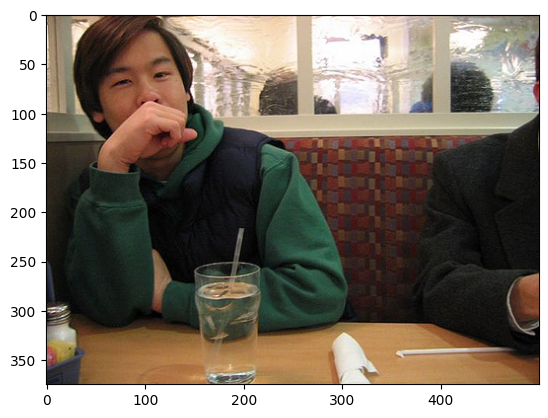

In [83]:
plt.imshow(Image.open(f'/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/{test.iloc[5,0]}'))
print(predict(f'/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/{test.iloc[5,0]}',img2seq,transform,vocab,sos_token,eos_token,25,device))